In [ ]:
from criminologia_cdmx.etl import *
from criminologia_cdmx.patrones_espacio_temporales import *
from criminologia_cdmx.covariables import *
from criminologia_cdmx.modelos import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import contextily as ctx
plt.style.use('ggplot')

In [ ]:
%load_ext autoreload
%autoreload 2

# Modelos

En este notebook vamos a desarrollar algunos flujos de trabajo completo para desarrollar, ajustar y comparar modelos criminológicos. 

## Robo a casa habitación sin violencia

El primer ejemplo completo que vamos a trabajar es sobre robo a casa habitación sin violencia. Lo que vamos a hacer es ajustar un modelo GLM utilizando sólo variables censales que describan la población y las viviendas de cada colonia y luego vamos a incluir alguinas variables de estructura urbana paracomparar los dos modelos

### Preparación de variable dependiente

Vamos a leer (desde un archivo) el total de las carpetas de investigación y realizaremos el siguiente preprocesamiento:

* Agregar ids espaciales (colonias y cuadrantes)
* Definimos fechas iniciales y finales para agregar los datos
* Usamos la función `variable_independiente` para extraere los datos entre las fechas de interés y agregar los incidentes en colonias

In [ ]:
carpetas = get_carpetas_desde_archivo("datos/descargas/carpetas_fiscalia.csv")
carpetas = agrega_ids_espaciales(carpetas)
fecha_inicio = "01-01-2019"
fecha_fin = "01-01-2022"
delito = 'ROBO A CASA HABITACION SIN VIOLENCIA'
Y = variable_independiente(carpetas, 'delito', delito, fecha_inicio, fecha_fin)
Y

,colonia_cve,ROBO A CASA HABITACION SIN VIOLENCIA
0,32,0.0
1,619,12.0
2,1792,5.0
3,1774,0.0
4,583,20.0
...,...,...
1819,1731,42.0
1820,1801,0.0
1821,1799,7.0
1822,1800,15.0


### Variables censales

Ahora vamos a preparar una `CapaDeAnalisis` utilizando sólo datos censales. Primero leemos los datos del censo, los agregamos en colonias y los pasamos a tasas.

In [ ]:
diccionario = get_diccionario_censo()
censo = get_variables_censo()
agregado = agrega_en_unidades(censo, diccionario)
agregado = censo_a_tasas(agregado, diccionario)
agregado.head()

,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3YMAS,P_3YMAS_F,P_3YMAS_M,P_5YMAS,...,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,OCUPVIVPAR,PROM_OCUP_C
colonia_cve,,,,,,,,,,,,,,,,,,,,,
0,5642.0,0.503545,0.496455,0.035271,0.015775,0.014711,0.959412,0.482630,0.476781,0.927331,...,0.527206,0.322794,0.142647,0.103676,0.016176,0.036765,0.435294,0.007353,5559.0,1.630683
1,7470.0,0.499063,0.500937,0.048059,0.020616,0.023025,0.949398,0.474297,0.475100,0.911111,...,0.505724,0.157790,0.076157,0.070184,0.013440,0.056247,0.453459,0.000000,7470.0,1.588686
2,7625.0,0.509377,0.490623,0.036197,0.014557,0.014820,0.959607,0.489180,0.470426,0.928656,...,0.623609,0.175617,0.134494,0.094340,0.007741,0.043058,0.330914,0.000000,7625.0,1.387878
3,1617.0,0.526283,0.473717,0.047001,0.024737,0.017316,0.951144,0.498454,0.452690,0.904143,...,0.546948,0.138498,0.068075,0.089202,0.000000,0.044601,0.389671,0.000000,1617.0,1.493075
4,4765.0,0.521511,0.478489,0.042183,0.017419,0.018888,0.955929,0.500735,0.455194,0.925289,...,0.580834,0.177030,0.091441,0.075347,0.010241,0.058522,0.383321,0.002195,4765.0,1.403121


Seleccionamos un par de variables que nos describan las viviendas en una colonia:

* Total de viviendas habitadas
* Viviendas con más de tres habitaciones

In [ ]:
vars_viv = agregado[['VIVPAR_HAB', 'VPH_3YMASC']]
vars_viv.head()

,VIVPAR_HAB,VPH_3YMASC
colonia_cve,,
0,1360.0,0.653676
1,2009.0,0.549029
2,2067.0,0.758587
3,426.0,0.676056
4,1367.0,0.628383


Construimos un índice para representar la Concentración de Desventajas a partir de las variables de población del censo

In [ ]:
vars_indice = ['P5_HLI', 'POB_AFRO', 'PCON_DISC', 'P3A5_NOA', 
               'P6A11_NOA', 'P12A14NOA', 'P15YM_AN', 'PSINDER', 'PDESOCUP']
diccionario[diccionario['Nombre del Campo'].isin(vars_indice)][['Nombre del Campo', 'Descripción']]

,Nombre del Campo,Descripción
69,P5_HLI,Personas de 5 a 130 años de edad que hablan al...
73,POB_AFRO,Personas que se consideran afromexicanos o afr...
76,PCON_DISC,Personas que realizan con mucha dificultad o n...
92,P3A5_NOA,Personas de 3 a 5 años de edad que no van a la...
95,P6A11_NOA,Personas de 6 a 11 años de edad que no van a l...
98,P12A14NOA,Personas de 12 a 14 años de edad que no van a ...
110,P15YM_AN,Personas de 15 a 130 años de edad que no saben...
143,PDESOCUP,Personas de 12 a 130 años de edad que no tenía...
146,PSINDER,Total de personas que no están afiliadas a ser...


Construimos un índice PCA utilizando la clase `IndicePCA` del módulo de `covariables`

In [ ]:
indice = IndicePCA(agregado, vars_indice)
indice.calcula_indice()
print(f'El porcentaje de la varianza explicada por el índice es {indice.varianza_explicada[0]}')

El porcentaje de la varianza explicada por el índice es 0.3139919934039488


Construimos un Dataframe con los datos de vivienda y el índice

In [ ]:
var_m1 = (vars_viv
          .join(indice.indice.set_index('colonia_cve'))
          .rename({'Índice': 'Concentración de Desventajas'}, axis=1))
var_m1

,VIVPAR_HAB,VPH_3YMASC,Concentración de Desventajas
colonia_cve,,,
0,1360.0,0.653676,3.549108
1,2009.0,0.549029,3.638010
2,2067.0,0.758587,1.045746
3,426.0,0.676056,2.574354
4,1367.0,0.628383,2.640318
...,...,...,...
1820,1756.0,0.801822,0.232755
1821,6610.0,0.821936,1.529263
1822,241.0,1.298755,1.942715


Hasta aquí ya tenemos nuestra variable dependiente y las covariables, entonces podemos crear una `CapaDeAnalisis`

In [ ]:
ca_censo = CapaDeAnalisis(Y, var_m1, 'colonia_cve')

La clase `CapaDeAnalisis` provee algunas herramientas para inspeccionar los datos, por ejemplo, podemos ver el histograma de la variable dependiente

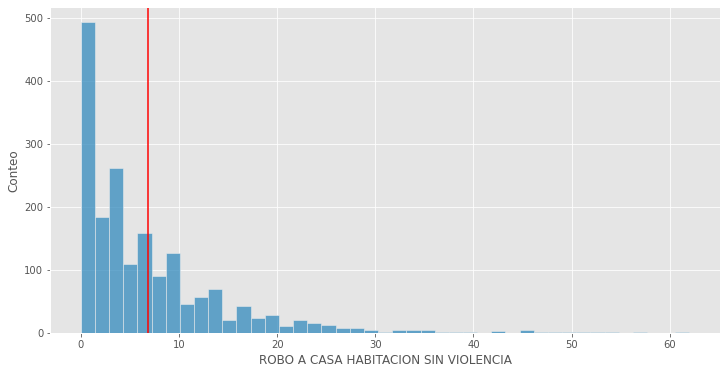

In [ ]:
ax = ca_censo.displot_Y()

También podemos ver una descripción de los datos

In [ ]:
ca_censo.describe_Y()

,
Estadístico,
N,1824.000000
Media,6.844846
Varianza,64.136638
Desviación estándar,8.008535
Mínimo,0.000000
25%,1.000000
50%,4.000000
75%,10.000000
Máximo,62.000000


Para las variables dependientes podemos ver una gráfica de la dispersión por pares

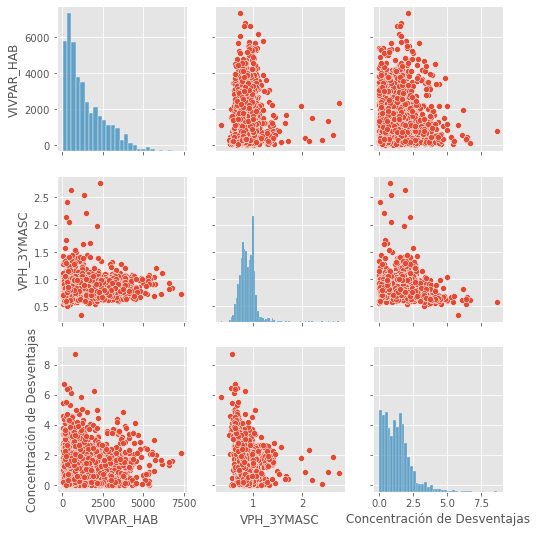

In [ ]:
g = ca_censo.pairplot_X()

#### Ajuste del primer modelo

Ya tenemos preparados nuestros datos con variables censales, ahora podemos construir y ajustar el modelo.

**NOTA:** Aquí puede haber discrepancias en el número de unidades porque `CapaDeAnalisis` tira las observaciones que tienen algún nulo (en las covariables). Eso puede ser real o puede haber algún error en el proceso. 

In [ ]:
m_censo = ModeloGLM(ca_censo, sm.families.NegativeBinomial(), 'Nulo')
r_censo = m_censo.fit()
r_censo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Generalized Linear Model Regression Results                             
=====================================================================================================
Dep. Variable:     Q('ROBO A CASA HABITACION SIN VIOLENCIA')   No. Observations:                 1809
Model:                                                   GLM   Df Residuals:                     1805
Model Family:                               NegativeBinomial   Df Model:                            3
Link Function:                                           log   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -4885.6
Date:                                       Thu, 31 Mar 2022   Deviance:                       1249.0
Time:                                               19:09:50   Pearson chi2:                 1.01e+03
No. Iterations:                                           11                                         
Covariance Type:                                   nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.3299      0.148     -2.230      0.026      -0.620      -0.040
Q('VIVPAR_HAB')                       0.0007   2.07e-05     33.445      0.000       0.001       0.001
Q('VPH_3YMASC')                       1.0757      0.146      7.353      0.000       0.789       1.362
Q('Concentración de Desventajas')    -0.0229      0.027     -0.859      0.391      -0.075       0.029
=====================================================================================================
"""

### Variables de uso de suelo

Ahora preparamos otro conjunto al que le vamos a pegar las variables de uso de suelo

In [ ]:
usos = get_uso_de_suelo()
usos = agrega_uso_suelo(usos, unidades='colonias')
usos.head()

,Industria,Comercio,Servicios,Intensidad,Entropía
colonia_cve,,,,,
1,8,87,44,139,-4.072303
2,15,112,55,182,-3.803105
3,2,22,7,31,-4.161488
4,9,55,31,95,-3.661970
5,31,144,66,241,-3.514375


In [ ]:
var_m2 = var_m1.join(usos)
var_m2.head()

,VIVPAR_HAB,VPH_3YMASC,Concentración de Desventajas,Industria,Comercio,Servicios,Intensidad,Entropía
colonia_cve,,,,,,,,
0,1360.0,0.653676,3.549108,NaN,NaN,NaN,NaN,NaN
1,2009.0,0.549029,3.638010,8.0,87.0,44.0,139.0,-4.072303
2,2067.0,0.758587,1.045746,15.0,112.0,55.0,182.0,-3.803105
3,426.0,0.676056,2.574354,2.0,22.0,7.0,31.0,-4.161488
4,1367.0,0.628383,2.640318,9.0,55.0,31.0,95.0,-3.661970


También creamos la capa de análisis y la inspeccionamos

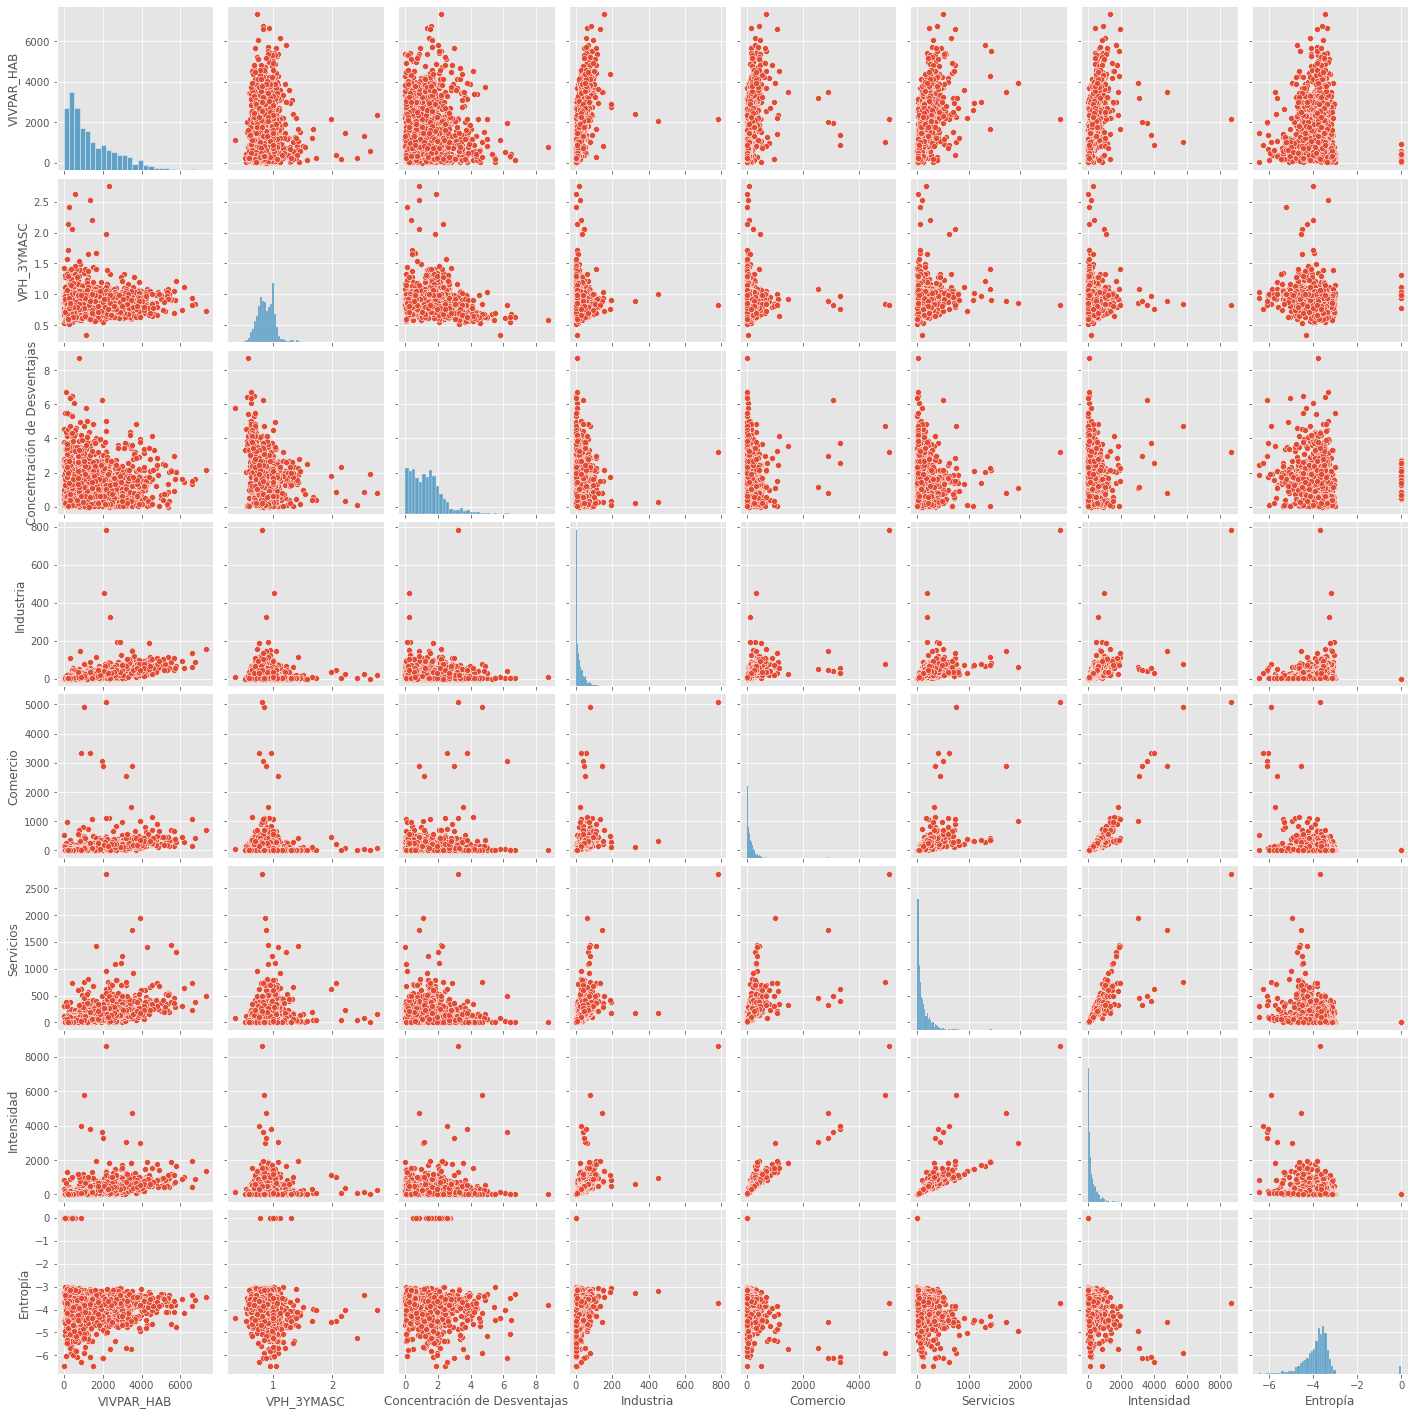

In [ ]:
ca_uso_suelo = CapaDeAnalisis(Y, var_m2, 'colonia_cve')
g = ca_uso_suelo.pairplot_X(14,1)

La verdad, parece que la variable intensidad no nos está aportando mucho (es sólo la suma de los usos de suelo), entonces la podemos quitar de los datos y recrear la capa

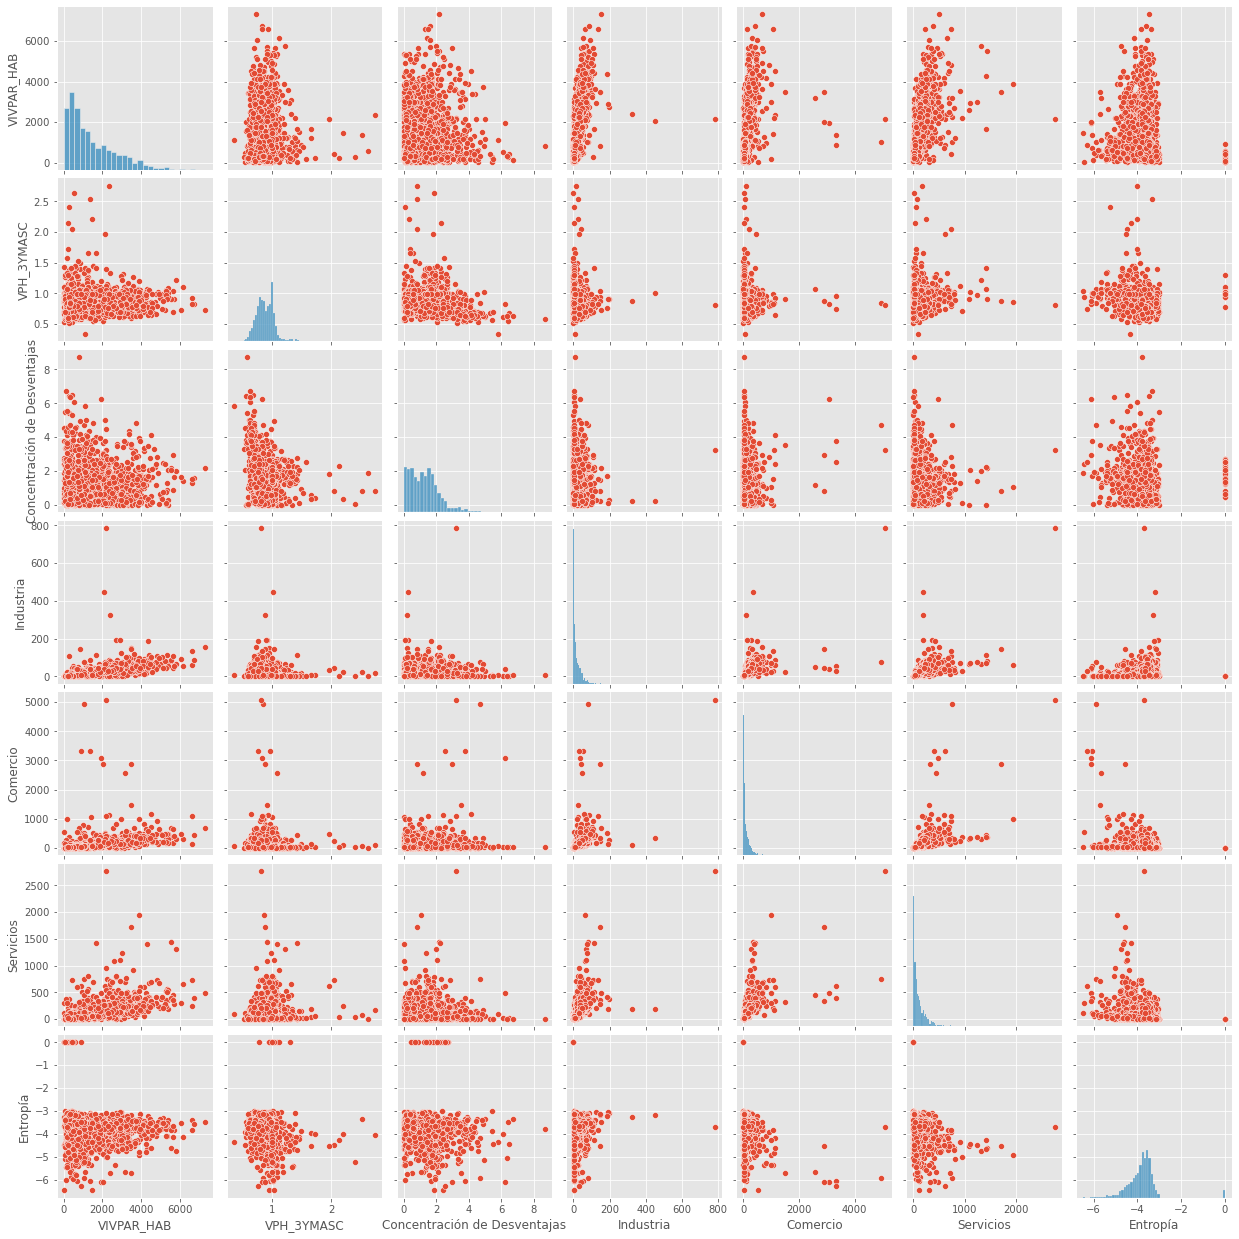

In [ ]:
var_m2 = var_m2.drop(columns='Intensidad')
ca_uso_suelo = CapaDeAnalisis(Y, var_m2, 'colonia_cve')
g = ca_uso_suelo.pairplot_X(14,1)

#### Ajuste del segundo modelo

In [ ]:
m_suelo = ModeloGLM(ca_uso_suelo, sm.families.NegativeBinomial(), "Uso de Suelo")
r_suelo = m_suelo.fit()
r_suelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Generalized Linear Model Regression Results                             
=====================================================================================================
Dep. Variable:     Q('ROBO A CASA HABITACION SIN VIOLENCIA')   No. Observations:                 1623
Model:                                                   GLM   Df Residuals:                     1615
Model Family:                               NegativeBinomial   Df Model:                            7
Link Function:                                           log   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -4542.9
Date:                                       Thu, 31 Mar 2022   Deviance:                       907.37
Time:                                               19:10:06   Pearson chi2:                     697.
No. Iterations:                                           10                                         
Covariance Type:                                   nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.8717      0.226     -3.859      0.000      -1.314      -0.429
Q('VIVPAR_HAB')                       0.0005    2.7e-05     19.733      0.000       0.000       0.001
Q('VPH_3YMASC')                       0.6635      0.166      3.988      0.000       0.337       0.990
Q('Concentración de Desventajas')    -0.0291      0.028     -1.028      0.304      -0.085       0.026
Q('Industria')                        0.0022      0.001      1.808      0.071      -0.000       0.005
Q('Comercio')                        -0.0004      0.000     -2.800      0.005      -0.001      -0.000
Q('Servicios')                        0.0011      0.000      4.715      0.000       0.001       0.002
Q('Entropía')                        -0.2750      0.048     -5.781      0.000      -0.368      -0.182
=====================================================================================================
"""

## Comparación de modelos

Para poder comparar fácilmente modelos, tenemos la clase `ComparaModelos` que nos ayuda a ver los resultados de forma sencilla

In [ ]:
compara = ComparaModelos([m_censo,m_suelo], ['coef', 'P>|z|'], 3)
compara.comparacion

Modelo Nulo        Modelo Uso de Suelo  \
                                         coef  P>|z|                coef   
Intercept                              -0.330  0.026              -0.872   
Q('VIVPAR_HAB')                         0.001  0.000               0.001   
Q('VPH_3YMASC')                         1.076  0.000               0.664   
Q('Concentración de Desventajas')      -0.023  0.391              -0.029   
Intercept                              -0.330  0.026              -0.872   
Q('VIVPAR_HAB')                         0.001  0.000               0.001   
Q('VPH_3YMASC')                         1.076  0.000               0.664   
Q('Concentración de Desventajas')      -0.023  0.391              -0.029   
Q('Industria')                            NaN    NaN               0.002   
Q('Comercio')                             NaN    NaN              -0.000   
Q('Servicios')                            NaN    NaN               0.001   
Q('Entropía')                             NaN    NaN              -0.275   

                                          
                                   P>|z|  
Intercept                          0.000  
Q('VIVPAR_HAB')                    0.000  
Q('VPH_3YMASC')                    0.000  
Q('Concentración de Desventajas')  0.304  
Intercept                          0.000  
Q('VIVPAR_HAB')                    0.000  
Q('VPH_3YMASC')                    0.000  
Q('Concentración de Desventajas')  0.304  
Q('Industria')                     0.071  
Q('Comercio')                      0.005  
Q('Servicios')                     0.000  
Q('Entropía')                      0.000